# Model Evaluation Notebook

This notebook evaluates Query2Label models with internal projection layers.
The model's PLM and BLM projection layers are saved within the checkpoint for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import json
import glob
import re

from Model.Query2Label_pl import Query2Label_pl
from Dataset.Utils import load_data
from Dataset.EmbeddingsDataset import EmbeddingsDataset, simple_collate, PrefetchLoaderWithRawFeatures
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Set the model directory you want to test
model_dir = "/mnt/d/ML/Kaggle/CAFA6-new/checkpoints/newModel_1+3_F"

In [2]:
# Load configs from the model directory
with open(os.path.join(model_dir, "configs.json"), "r") as f:
    configs = json.load(f)

model_configs = configs.get("model_configs", {})
training_configs = configs.get("training_configs", {})
data_paths = configs.get("data_paths", {})

print("Model configs:", json.dumps(model_configs, indent=2))
print("\nTraining configs:", json.dumps(training_configs, indent=2))

Model configs: {
  "token_dim": 512,
  "num_tokens": 64,
  "num_plm_tokens": 32,
  "num_blm_tokens": 32,
  "max_terms": 64,
  "nheads": 8,
  "num_encoder_layers": 1,
  "num_decoder_layers": 3,
  "dim_feedforward": 2048,
  "dropout": 0.3
}

Training configs: {
  "aspect": "F",
  "val_fraction": 0.3,
  "max_epochs": 20,
  "batch_size": 64,
  "num_workers": 0,
  "sampling_strategy": "log_pos",
  "loss_function": "WBCE",
  "epsilon": 0.5,
  "lr": 0.0001,
  "weight_decay": 0,
  "patience": 5,
  "devices": "auto",
  "log_dir": "./lightning_logs",
  "checkpoint_dir": "./checkpoints",
  "save_top_k": 1,
  "seed": 42,
  "warmup_steps": 200,
  "accumulate_grad_batches": 2,
  "freeze_tokenizer": true
}


In [3]:
# Find the best checkpoint based on the validation F1 score in the filename
checkpoint_files = glob.glob(os.path.join(model_dir, "*.ckpt"))

if not checkpoint_files:
    raise FileNotFoundError(f"No checkpoint files found in {model_dir}")

best_checkpoint = None
best_metric = -float('inf')

for ckpt_file in checkpoint_files:
    match = re.search(r'val_f1_macro_go=([0-9]+\.[0-9]+)', ckpt_file)
    if match:
        metric_value = float(match.group(1))
        if metric_value > best_metric:
            best_metric = metric_value
            best_checkpoint = ckpt_file

if best_checkpoint is None:
    best_checkpoint = checkpoint_files[0]
    print(f"Warning: Could not parse metrics. Using first checkpoint: {os.path.basename(best_checkpoint)}")
else:
    print(f"Found best checkpoint with val_f1_macro_go={best_metric:.4f}: {os.path.basename(best_checkpoint)}")

# Load the model from the best checkpoint (with internal projection layers)
model = Query2Label_pl.load_from_checkpoint(
    best_checkpoint,
    strict=False
)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\nModel loaded successfully!")
print(f"Model is on device: {device}")
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"PLM projections: {len(model.model.plm_projections)} layers")
print(f"BLM projection: 1 shared layer")

Found best checkpoint with val_f1_macro_go=0.3985: epoch=09-val_f1_macro_go=0.3985.ckpt

Model loaded successfully!
Model is on device: cuda
Model has 37,179,968 parameters
PLM projections: 32 layers
BLM projection: 1 shared layer


In [4]:
# Prepare data using the same function and configs as in training
max_terms = model_configs.get('max_terms', None)
aspect = training_configs.get('aspect', None)

print(f"Preparing data with aspect='{aspect}' and max_terms={max_terms}...")
data = load_data(data_paths, max_terms=max_terms, aspect=aspect)
print("Data preparation complete!")
print(f"Number of sequences: {len(data['seq_2_terms'])}")
print(f"Number of GO embeddings: {len(data['go_embeds'])}")
print(f"Number of PLM embeddings: {len(data['plm_embeds'])}")
print(f"Number of BLM embeddings: {len(data['pmid_2_embed'])}")

Preparing data with aspect='F' and max_terms=64...
Loading PLM features...
Loading BLM data (protein to PMID mapping and PMID embeddings)...
filtering by aspect: F
Padding terms_predicted with random terms from aspect F...


Padding with random F terms:   0%|          | 0/57960 [00:00<?, ?it/s]

After padding - Min: 64, Max: 64, Mean: 64.00
Filtering sequences by term lengths and PLM features availability...
After filtering: 57960 sequences with both PLM features and GO terms
Data preparation complete!
Number of sequences: 57960
Number of GO embeddings: 40122
Number of PLM embeddings: 287001
Number of BLM embeddings: 194271


In [5]:
# Check if all true predictions from train_terms_all are present in terms_predicted
def check_coverage(row):
    """Check what percentage of train_terms_all are in terms_predicted"""
    # Check if train_terms_all is None or empty list
    if row['terms_true'] is None or (isinstance(row['terms_true'], list) and len(row['terms_true']) == 0):
        return None
    
    train_set = set(row['terms_true'])
    pred_set = set(row['terms_predicted'])
    
    # Find terms in train_terms_all that are in terms_predicted
    covered_terms = train_set.intersection(pred_set)
    
    # Calculate coverage percentage
    coverage = len(covered_terms) / len(train_set) * 100 if len(train_set) > 0 else 0
    
    return {
        'total_train_terms': len(train_set),
        'covered_terms': len(covered_terms),
        'missing_terms': len(train_set) - len(covered_terms),
        'coverage_pct': coverage,
        'missing_term_list': list(train_set - covered_terms)
    }

# Apply the check
coverage_results = data['seq_2_terms'].apply(check_coverage, axis=1)
coverage_df = pd.DataFrame(coverage_results.tolist())

# Combine with original data
analysis_df = pd.concat([data['seq_2_terms'], coverage_df], axis=1)
print("=== Coverage Analysis ===")
print(f"\nOverall Statistics:")
print(f"Average coverage: {coverage_df['coverage_pct'].mean():.2f}%")
print(f"Median coverage: {coverage_df['coverage_pct'].median():.2f}%")
print(f"Min coverage: {coverage_df['coverage_pct'].min():.2f}%")
print(f"Max coverage: {coverage_df['coverage_pct'].max():.2f}%")
print(f"\nRows with 100% coverage: {(coverage_df['coverage_pct'] == 100).sum()} / {len(coverage_df)}")
print(f"Rows with 0% coverage: {(coverage_df['coverage_pct'] == 0).sum()} / {len(coverage_df)}")
print(f"\nAverage missing terms per row: {coverage_df['missing_terms'].mean():.2f}")
print(f"Total train terms checked: {coverage_df['total_train_terms'].sum()}")
print(f"Total covered terms: {coverage_df['covered_terms'].sum()}")
print(f"Total missing terms: {coverage_df['missing_terms'].sum()}")

=== Coverage Analysis ===

Overall Statistics:
Average coverage: 91.60%
Median coverage: 100.00%
Min coverage: 0.00%
Max coverage: 100.00%

Rows with 100% coverage: 52364 / 57960
Rows with 0% coverage: 4287 / 57960

Average missing terms per row: 0.14
Total train terms checked: 128399
Total covered terms: 120245
Total missing terms: 8154


In [6]:
# Create dataset and dataloader for the full training set
all_indices = list(range(len(data['seq_2_terms'])))
test_dataset = EmbeddingsDataset(data, oversample_indices=all_indices)

batch_size = training_configs.get('batch_size', 32)
num_workers = training_configs.get('num_workers', 0)

# Use simple_collate because BLM embeddings can have variable lengths
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(num_workers > 0),
    collate_fn=simple_collate
)

# Wrap with PrefetchLoaderWithRawFeatures (model has internal projections)
num_blm_tokens = model_configs.get('num_blm_tokens', 32)

test_loader = PrefetchLoaderWithRawFeatures(
    test_loader,
    device,
    num_blm_tokens=num_blm_tokens
)

print(f"Dataloader created for {len(test_dataset)} samples.")
print(f"Batch size: {batch_size}, Num BLM tokens: {num_blm_tokens}")

PLM dim: 1280, BLM dim: 768
Dataloader created for 57960 samples.
Batch size: 64, Num BLM tokens: 32


In [7]:
batch = next(iter(test_loader))
batch.keys()

dict_keys(['entryID', 'plm_raw', 'blm_raw', 'blm_mask', 'go_embed', 'label', 'predicted_terms', 'true_terms'])

In [8]:
# Run inference to get model predictions
predictions_list = []
true_list = []
entry_ids_list = []
true_terms = []
term_list = []
print(f"Running inference on {len(test_dataset)} samples...")

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Inference")):
        # Debug: check what keys are actually in the batch
        if batch_idx == 0:
            print(f"Available batch keys: {list(batch.keys())}")
            for key, value in batch.items():
                if torch.is_tensor(value):
                    print(f"  {key}: {value.shape} ({value.dtype})")
                else:
                    print(f"  {key}: {type(value)} (length: {len(value) if hasattr(value, '__len__') else 'N/A'})")
        
        # Extract inputs
        x = batch['go_embed']  # GO embedding tokens
        plm_raw = batch['plm_raw']  # Raw PLM features
        blm_raw = batch['blm_raw']  # Raw BLM features
        blm_mask = batch.get('blm_mask', None)  # BLM mask
        true_labels = batch['label']
        term_list.extend(batch['predicted_terms'])
        
        # Store metadata
        entry_ids_list.extend(batch['entryID'])
        true_terms.extend(batch['true_terms'])
        
        # Forward pass with raw features (model projects internally)
        logits = model(x, plm_raw=plm_raw, blm_raw=blm_raw, blm_mask=blm_mask)
        probs = torch.sigmoid(logits)
        
        # Store results
        predictions_list.append(probs.cpu().numpy())
        true_list.append(true_labels.cpu().numpy())

print("\nInference complete!")

Running inference on 57960 samples...


Inference:   0%|          | 0/906 [00:00<?, ?it/s]

Available batch keys: ['entryID', 'plm_raw', 'blm_raw', 'blm_mask', 'go_embed', 'label', 'predicted_terms', 'true_terms']
  entryID: <class 'list'> (length: 64)
  plm_raw: torch.Size([64, 1280]) (torch.float32)
  blm_raw: torch.Size([64, 32, 768]) (torch.float32)
  blm_mask: torch.Size([64, 32]) (torch.bool)
  go_embed: torch.Size([64, 64, 512]) (torch.float32)
  label: torch.Size([64, 64]) (torch.float32)
  predicted_terms: <class 'list'> (length: 64)
  true_terms: <class 'list'> (length: 64)


/home/tan/miniconda3/envs/cafa6/lib/python3.12/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Inference complete!


In [9]:
predictions_list = np.vstack(predictions_list)
true_list = np.vstack(true_list)

print(f"Predictions array shape: {predictions_list.shape}")
print(f"True labels array shape: {true_list.shape}")

Predictions array shape: (57960, 64)
True labels array shape: (57960, 64)


Text(0.5, 0, 'Term Index')

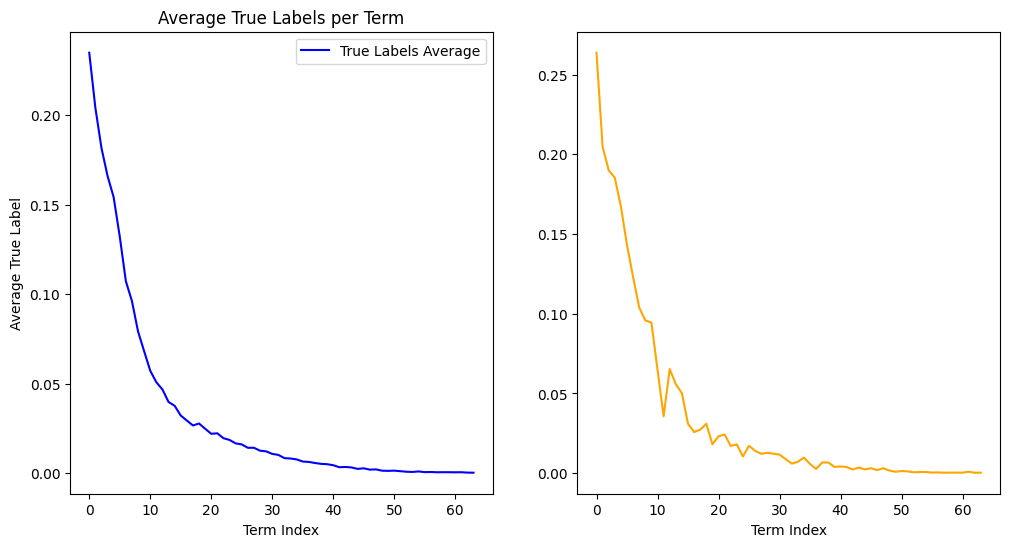

In [10]:
# predictions_list.mean(axis=0)
#plot avergae  probability for true and predicted side by side 

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(true_list.mean(axis=0), label='True Labels Average', color='blue')
ax[0].set_xlabel('Term Index')
ax[0].set_ylabel('Average True Label')
ax[0].set_title('Average True Labels per Term')
ax[0].legend()
ax[1].plot(predictions_list.mean(axis=0), label='Predicted Probabilities Average', color='orange')
ax[1].set_xlabel('Term Index')      

In [11]:
#create gt dictionary from entry_ids_list and true_terms
gt_dict = {entry_id: set(terms) for entry_id, terms in zip(entry_ids_list, true_terms)}
term_list = np.array(term_list)

In [12]:
next(iter(gt_dict.items()))

('A0A023FBW4', {'GO:0019958'})

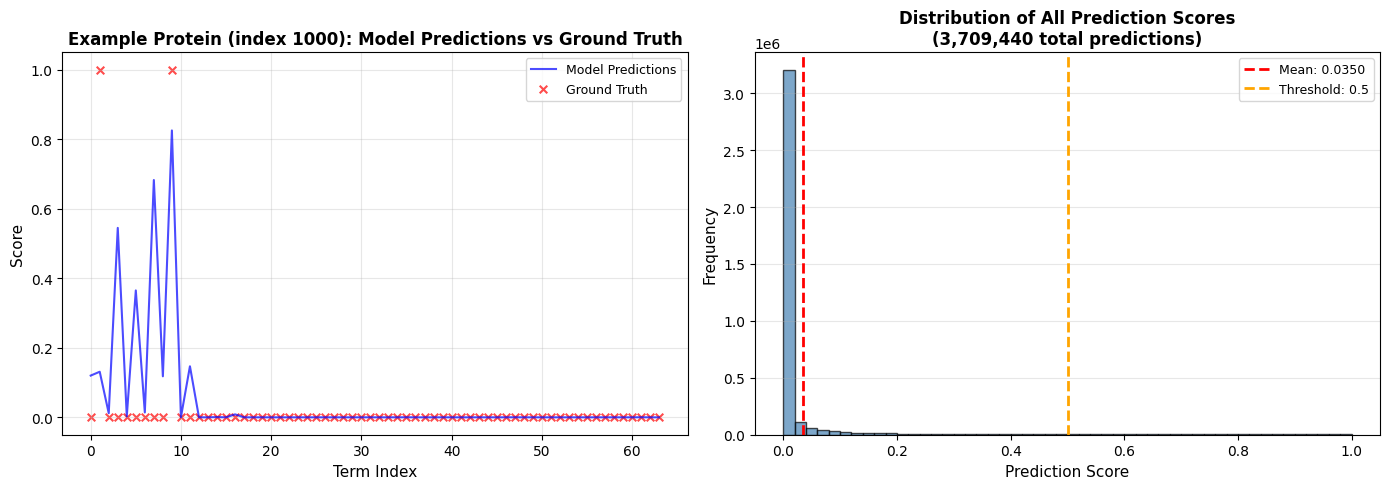


Prediction score statistics:
  Mean: 0.0350
  Median: 0.0001
  Std: 0.1352
  Predictions > 0.5: 93,736 (2.53%)


In [14]:
# Visualize model predictions vs ground truth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot example protein predictions vs ground truth
sample_idx = 1000
x_vals = np.arange(len(predictions_list[sample_idx]))

axes[0].plot(x_vals, predictions_list[sample_idx], alpha=0.7, label='Model Predictions', linewidth=1.5, color='blue')
axes[0].scatter(x_vals, true_list[sample_idx], color='red', s=30, alpha=0.7, label='Ground Truth', marker='x')
axes[0].set_xlabel('Term Index', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title(f'Example Protein (index {sample_idx}): Model Predictions vs Ground Truth', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot distribution of all prediction scores
all_predictions = predictions_list.flatten()

axes[1].hist(all_predictions, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[1].set_xlabel('Prediction Score', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Distribution of All Prediction Scores\n({len(all_predictions):,} total predictions)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axvline(all_predictions.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_predictions.mean():.4f}')
axes[1].axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Threshold: 0.5')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nPrediction score statistics:")
print(f"  Mean: {all_predictions.mean():.4f}")
print(f"  Median: {np.median(all_predictions):.4f}")
print(f"  Std: {all_predictions.std():.4f}")
print(f"  Predictions > 0.5: {np.sum(all_predictions > 0.5):,} ({np.sum(all_predictions > 0.5)/len(all_predictions)*100:.2f}%)")

In [27]:
# Analyze model prediction characteristics
print("="*80)
print("MODEL PREDICTION ANALYSIS")
print("="*80)

# Basic statistics about predictions
print(f"\nPrediction Statistics:")
print(f"  Total predictions: {predictions_list.size:,}")
print(f"  Mean prediction score: {predictions_list.mean():.4f}")
print(f"  Median prediction score: {np.median(predictions_list):.4f}")
print(f"  Std prediction score: {predictions_list.std():.4f}")
print(f"  Min/Max prediction scores: [{predictions_list.min():.4f}, {predictions_list.max():.4f}]")

# Count predictions by threshold
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
print(f"\nPredictions above different thresholds:")
for thresh in thresholds:
    count = np.sum(predictions_list > thresh)
    pct = count / predictions_list.size * 100
    print(f"  > {thresh}: {count:,} ({pct:.2f}%)")

# Ground truth statistics
print(f"\nGround Truth Statistics:")
print(f"  Total ground truth labels: {true_list.size:,}")
print(f"  Positive labels: {np.sum(true_list > 0.5):,} ({np.sum(true_list > 0.5)/true_list.size*100:.2f}%)")
print(f"  Negative labels: {np.sum(true_list <= 0.5):,} ({np.sum(true_list <= 0.5)/true_list.size*100:.2f}%)")

MODEL PREDICTION ANALYSIS

Prediction Statistics:
  Total predictions: 3,709,440
  Mean prediction score: 0.0350
  Median prediction score: 0.0001
  Std prediction score: 0.1352
  Min/Max prediction scores: [0.0000, 0.9996]

Predictions above different thresholds:
  > 0.1: 267,979 (7.22%)
  > 0.2: 185,558 (5.00%)
  > 0.3: 143,074 (3.86%)
  > 0.4: 114,878 (3.10%)
  > 0.5: 93,670 (2.53%)
  > 0.6: 76,311 (2.06%)
  > 0.7: 61,183 (1.65%)
  > 0.8: 46,679 (1.26%)
  > 0.9: 30,533 (0.82%)

Ground Truth Statistics:
  Total ground truth labels: 3,709,440
  Positive labels: 120,241 (3.24%)
  Negative labels: 3,589,199 (96.76%)


In [15]:
# Load IA scores for weighted metric calculation
ia_file_path = data_paths.get('ia_file_path')
if ia_file_path and os.path.exists(ia_file_path):
    ia_df = pd.read_csv(ia_file_path, sep="\\t", header=None, engine='python')
    ia_df.columns = ['terms', 'ia']
    print(f"Loaded {len(ia_df)} IA scores from {ia_file_path}")
else:
    ia_df = None
    print("IA file not found or specified, will use unweighted metrics.")
ia_df.head()

Loaded 40122 IA scores from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/IA.tsv


,terms,ia
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573


## Compute F1

In [16]:
# Compute F-max function (adapted from test.py)
def compute_f1(gt_dict, predictions_array, entry_ids, terms_lists, threshold=0.5, ia_df=None):
    """
    Compute macro F1, precision, and recall for predictions.
    Calculates metrics for each entry individually, then averages them.
    
    Args:
        gt_dict: Dictionary mapping EntryID to set of true GO terms
        predictions_array: (N, M) array of prediction scores
        entry_ids: List of N entry IDs
        terms_lists: List of N term lists (each with M terms)
        threshold: Probability threshold for filtering predictions (only scores >= threshold are kept)
        ia_df: Optional DataFrame with columns ['terms', 'ia'] for IA-weighted metrics.
               If provided, metrics will be weighted by IA scores.
    
    Returns:
        dict with f1, precision, recall (macro-averaged)
    """
    # Build IA dictionary if provided
    ia_dict = {}
    use_ia_weighting = ia_df is not None
    if use_ia_weighting:
        ia_dict = dict(zip(ia_df['terms'], ia_df['ia']))
        print(f"Using IA weighting with {len(ia_dict)} terms")
    
    print(f"Building prediction dictionary with threshold >= {threshold}...")
    # Build prediction dict by filtering predictions above threshold
    pred_dict = {}
    for i in range(len(entry_ids)):
        entry_id = entry_ids[i]
        terms = terms_lists[i]
        scores = predictions_array[i]
        
        # Filter by threshold
        above_threshold_indices = np.where(scores >= threshold)[0]
        pred_terms = set(terms[idx] for idx in above_threshold_indices)
        
        if pred_terms:  # Only add if there are predictions above threshold
            pred_dict[entry_id] = pred_terms
    
    print(f"Total entries with predictions: {len(pred_dict)}")
    print(f"Total entries with ground truth: {len(gt_dict)}")
    
    # Get all entry IDs
    all_entries = set(gt_dict.keys()) | set(pred_dict.keys())
    
    # Calculate per-entry metrics for macro averaging
    precisions = []
    recalls = []
    f1_scores = []
    
    total_tp = 0.0
    total_fp = 0.0
    total_fn = 0.0
    
    for entry_id in all_entries:
        true_terms = gt_dict.get(entry_id, set())
        pred_terms = pred_dict.get(entry_id, set())
        
        if use_ia_weighting:
            # Weighted by IA scores
            tp = sum(ia_dict.get(term, 0.0) for term in (true_terms & pred_terms))
            fp = sum(ia_dict.get(term, 0.0) for term in (pred_terms - true_terms))
            fn = sum(ia_dict.get(term, 0.0) for term in (true_terms - pred_terms))
        else:
            # Unweighted (count)
            tp = len(true_terms & pred_terms)
            fp = len(pred_terms - true_terms)
            fn = len(true_terms - pred_terms)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        # Calculate per-entry metrics
        entry_precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        entry_recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        entry_f1 = 2 * entry_precision * entry_recall / (entry_precision + entry_recall) if (entry_precision + entry_recall) > 0 else 0.0
        
        precisions.append(entry_precision)
        recalls.append(entry_recall)
        f1_scores.append(entry_f1)
    
    # Macro-average: average across all entries
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    
    metric_type = "IA-weighted" if use_ia_weighting else "Unweighted"
    print(f"Total {metric_type} TP: {total_tp:.2f}, FP: {total_fp:.2f}, FN: {total_fn:.2f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    
    return {
        'f1': macro_f1,
        'precision': macro_precision,
        'recall': macro_recall,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn
    }

# Test with threshold = 0.5
print("=== Metrics with threshold >= 0.5 ===")
metrics_full = compute_f1(gt_dict, predictions_list, entry_ids_list, term_list, threshold=0.5)

=== Metrics with threshold >= 0.5 ===
Building prediction dictionary with threshold >= 0.5...
Total entries with predictions: 48032
Total entries with ground truth: 57960
Total Unweighted TP: 66083.00, FP: 27653.00, FN: 62316.00
Macro Precision: 0.6082
Macro Recall: 0.5510
Macro F1: 0.5465


## Comparision with unweighted f1

COMPARISON: Unweighted vs IA-Weighted Metrics (threshold=0.5)

--- Unweighted Metrics ---
Building prediction dictionary with threshold >= 0.5...
Total entries with predictions: 48038
Total entries with ground truth: 57960
Total Unweighted TP: 66084.00, FP: 27586.00, FN: 62315.00
Macro Precision: 0.6083
Macro Recall: 0.5512
Macro F1: 0.5465

--- IA-Weighted Metrics ---
Using IA weighting with 40122 terms
Building prediction dictionary with threshold >= 0.5...
Total entries with predictions: 48038
Total entries with ground truth: 57960
Total IA-weighted TP: 115890.12, FP: 39277.84, FN: 104712.95
Macro Precision: 0.6132
Macro Recall: 0.5455
Macro F1: 0.5201

SUMMARY
Metric Type  Precision   Recall       F1            TP           FP            FN
 Unweighted   0.608272 0.551244 0.546524  66084.000000 27586.000000  62315.000000
IA-Weighted   0.613222 0.545545 0.520136 115890.121941 39277.838726 104712.949027


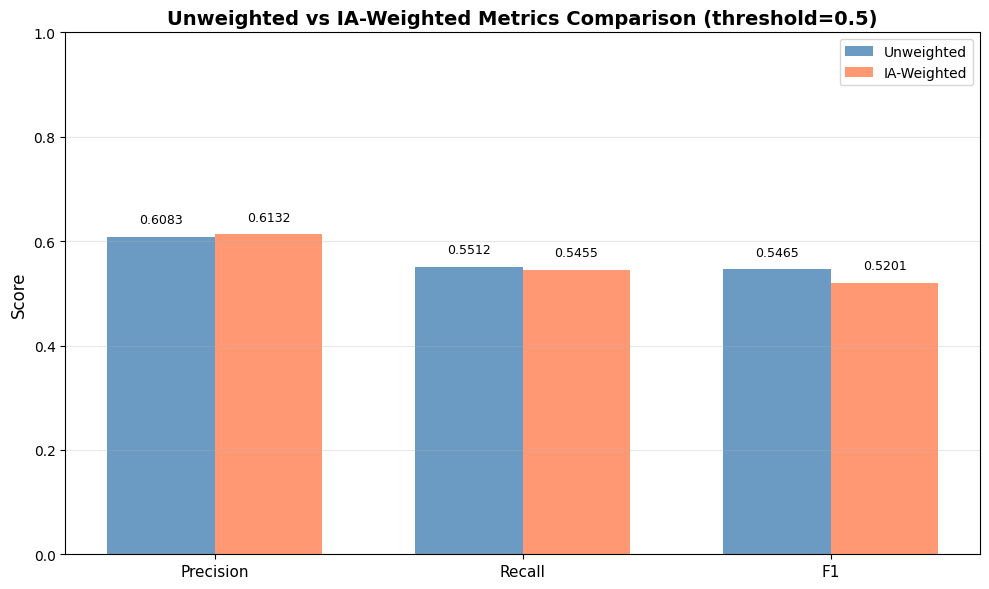

In [32]:
# Compare unweighted vs IA-weighted metrics with different thresholds
print("="*80)
print("COMPARISON: Unweighted vs IA-Weighted Metrics (threshold=0.5)")
print("="*80)

print("\n--- Unweighted Metrics ---")
metrics_unweighted = compute_f1(gt_dict, predictions_list, entry_ids_list, term_list, threshold=0.5, ia_df=None)

print("\n--- IA-Weighted Metrics ---")
metrics_ia_weighted = compute_f1(gt_dict, predictions_list, entry_ids_list, term_list, threshold=0.5, ia_df=ia_df)

# Create comparison table
comparison_data = {
    'Metric Type': ['Unweighted', 'IA-Weighted'],
    'Precision': [metrics_unweighted['precision'], metrics_ia_weighted['precision']],
    'Recall': [metrics_unweighted['recall'], metrics_ia_weighted['recall']],
    'F1': [metrics_unweighted['f1'], metrics_ia_weighted['f1']],
    'TP': [metrics_unweighted['tp'], metrics_ia_weighted['tp']],
    'FP': [metrics_unweighted['fp'], metrics_ia_weighted['fp']],
    'FN': [metrics_unweighted['fn'], metrics_ia_weighted['fn']]
}

comparison_metrics_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(comparison_metrics_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

metrics_to_plot = ['Precision', 'Recall', 'F1']
x = np.arange(len(metrics_to_plot))
width = 0.35

unweighted_vals = [metrics_unweighted['precision'], metrics_unweighted['recall'], metrics_unweighted['f1']]
weighted_vals = [metrics_ia_weighted['precision'], metrics_ia_weighted['recall'], metrics_ia_weighted['f1']]

ax.bar(x - width/2, unweighted_vals, width, label='Unweighted', alpha=0.8, color='steelblue')
ax.bar(x + width/2, weighted_vals, width, label='IA-Weighted', alpha=0.8, color='coral')
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Unweighted vs IA-Weighted Metrics Comparison (threshold=0.5)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

# Add value labels on bars
for i, (unw_val, w_val) in enumerate(zip(unweighted_vals, weighted_vals)):
    ax.text(i - width/2, unw_val + 0.02, f'{unw_val:.4f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, w_val + 0.02, f'{w_val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## F-maxxing

Testing Different Probability Thresholds

=== Threshold = 0.05 ===
Using IA weighting with 40122 terms
Building prediction dictionary with threshold >= 0.05...
Total entries with predictions: 55083
Total entries with ground truth: 57960
Total IA-weighted TP: 187607.11, FP: 501716.46, FN: 32995.96
Macro Precision: 0.3134
Macro Recall: 0.8218
Macro F1: 0.3842

=== Threshold = 0.1 ===
Using IA weighting with 40122 terms
Building prediction dictionary with threshold >= 0.1...
Total entries with predictions: 54459
Total entries with ground truth: 57960
Total IA-weighted TP: 176575.68, FP: 304836.45, FN: 44027.39
Macro Precision: 0.3989
Macro Recall: 0.7794
Macro F1: 0.4541

=== Threshold = 0.2 ===
Using IA weighting with 40122 terms
Building prediction dictionary with threshold >= 0.2...
Total entries with predictions: 53493
Total entries with ground truth: 57960
Total IA-weighted TP: 159399.07, FP: 159125.18, FN: 61204.00
Macro Precision: 0.5061
Macro Recall: 0.7121
Macro F1: 0.5206

=== T

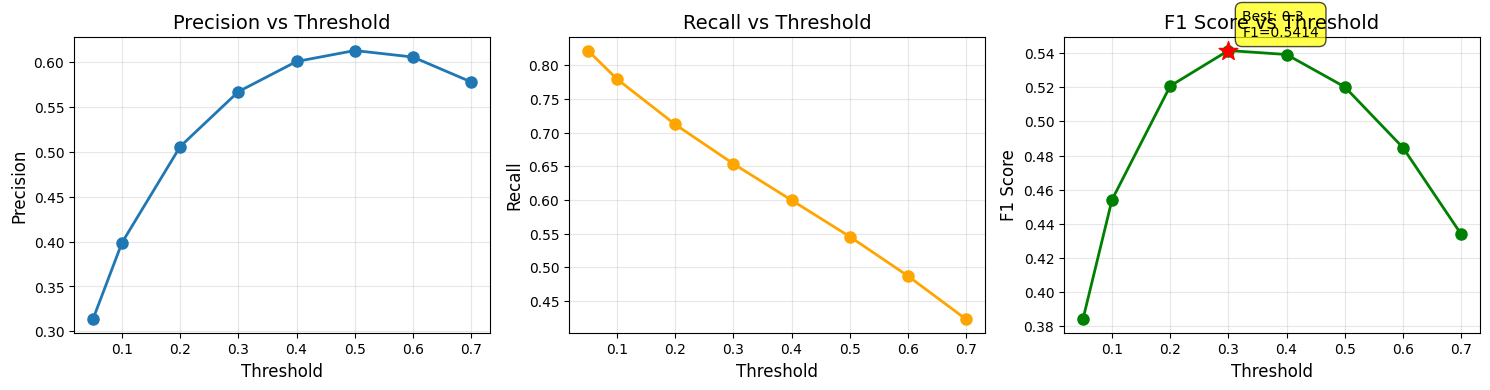

In [33]:
# Test with different probability thresholds
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

print("="*80)
print("Testing Different Probability Thresholds")
print("="*80)

for thresh in thresholds:
    print(f"\n{'='*60}")
    print(f"=== Threshold = {thresh} ===")
    print(f"{'='*60}")
    
    metrics = compute_f1(gt_dict, predictions_list, entry_ids_list, term_list, threshold=thresh, ia_df=ia_df)
    metrics['threshold'] = thresh
    threshold_results.append(metrics)

# Create results DataFrame
threshold_results_df = pd.DataFrame(threshold_results)
print("\n" + "="*80)
print("SUMMARY: Metrics by Threshold")
print("="*80)
print(threshold_results_df[['threshold', 'precision', 'recall', 'f1']])

# Find best threshold
best_idx = threshold_results_df['f1'].idxmax()
best_thresh = threshold_results_df.loc[best_idx, 'threshold']
best_f1 = threshold_results_df.loc[best_idx, 'f1']
print(f"\nBest F1 Score: {best_f1:.4f} at threshold = {best_thresh}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Precision
axes[0].plot(threshold_results_df['threshold'], threshold_results_df['precision'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision vs Threshold', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Plot Recall
axes[1].plot(threshold_results_df['threshold'], threshold_results_df['recall'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall vs Threshold', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Plot F1
axes[2].plot(threshold_results_df['threshold'], threshold_results_df['f1'], marker='o', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Threshold', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_title('F1 Score vs Threshold', fontsize=14)
axes[2].grid(True, alpha=0.3)

# Mark best F1
axes[2].scatter([best_thresh], [best_f1], color='red', s=200, zorder=5, marker='*')
axes[2].annotate(f'Best: {best_thresh}\nF1={best_f1:.4f}', 
                 xy=(best_thresh, best_f1), 
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## Cluster Analysis

Analyze GO term similarity within and across clusters from MMseqs2 clustering.

In [17]:
# Load cluster information from MMseqs2
from typing import Dict

def read_mmseqs_clusters(tsv_path: str) -> Dict[str, int]:
    """
    Parse MMseqs2 clusters.tsv (rep \t member) into protein_id -> cluster_index.
    All members of the same representative get the same integer cluster id.
    """
    rep_to_cluster = {}
    prot_to_cluster = {}

    with open(tsv_path, "r") as f:
        for line in f:
            rep, member = line.rstrip("\n").split("\t")
            if rep not in rep_to_cluster:
                rep_to_cluster[rep] = len(rep_to_cluster)
            cid = rep_to_cluster[rep]
            prot_to_cluster[member] = cid
            # also mark representative itself
            if rep not in prot_to_cluster:
                prot_to_cluster[rep] = cid

    return prot_to_cluster

clusters_path = "/mnt/d/ML/Kaggle/CAFA6-new/mmseq/clusters.tsv"

print("Loading cluster information...")
prot_to_cluster = read_mmseqs_clusters(clusters_path)

print(f"Loaded {len(prot_to_cluster)} proteins with cluster assignments")
print(f"Number of unique clusters: {len(set(prot_to_cluster.values()))}")

# Show first few mappings
print(f"\nFirst 10 protein -> cluster mappings:")
for i, (prot, cluster) in enumerate(list(prot_to_cluster.items())[:10]):
    print(f"  {prot} -> Cluster {cluster}")

Loading cluster information...
Loaded 82404 proteins with cluster assignments
Number of unique clusters: 46671

First 10 protein -> cluster mappings:
  Q9LTW5 -> Cluster 0
  Q9LZF8 -> Cluster 1
  Q9SF86 -> Cluster 1
  Q9QYP6 -> Cluster 2
  Q9H6S1 -> Cluster 2
  Q9S7G7 -> Cluster 3
  Q9SHZ6 -> Cluster 4
  Q9SPL2 -> Cluster 5
  Q9SUW2 -> Cluster 6
  Q9U7D5 -> Cluster 7


Cluster size statistics:
  Mean cluster size: 1.77
  Median cluster size: 1
  Min cluster size: 1
  Max cluster size: 77

Top 10 largest clusters:
44075    77
27123    72
13224    64
5159     55
24694    53
20298    51
42270    50
16793    48
4718     45
11314    44
dtype: int64


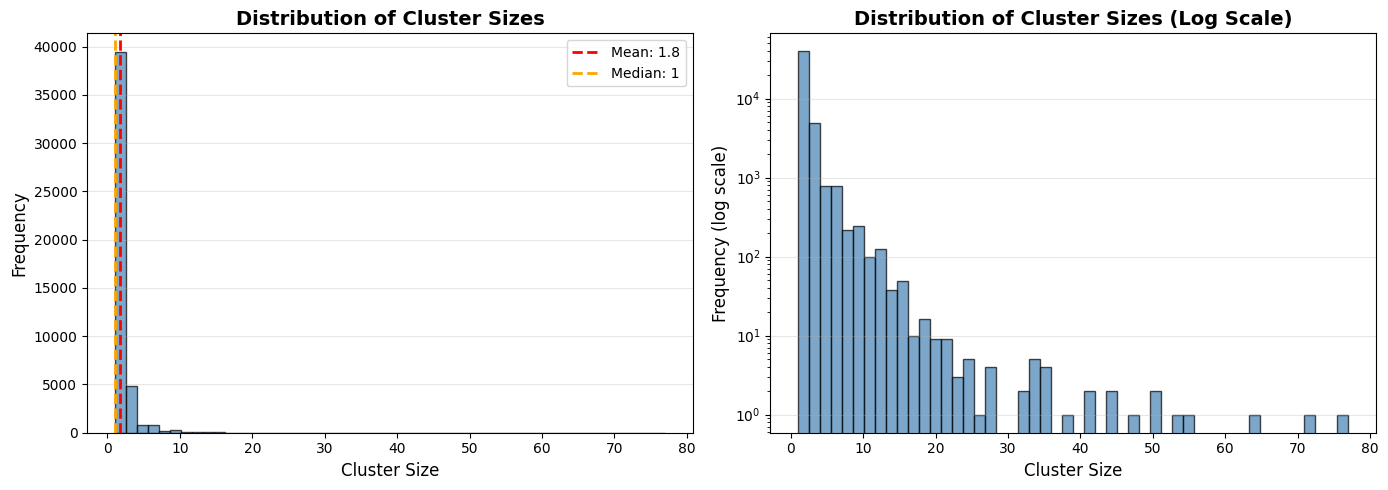

In [18]:
# Create cluster to members mapping (reverse the prot_to_cluster dict)
from collections import defaultdict

cluster_to_members = defaultdict(list)
for prot, cluster_id in prot_to_cluster.items():
    cluster_to_members[cluster_id].append(prot)

# Convert to regular dict
cluster_to_members = dict(cluster_to_members)

# Get cluster sizes
cluster_sizes = {cluster: len(members) for cluster, members in cluster_to_members.items()}
cluster_sizes_series = pd.Series(cluster_sizes).sort_values(ascending=False)

print(f"Cluster size statistics:")
print(f"  Mean cluster size: {cluster_sizes_series.mean():.2f}")
print(f"  Median cluster size: {cluster_sizes_series.median():.0f}")
print(f"  Min cluster size: {cluster_sizes_series.min()}")
print(f"  Max cluster size: {cluster_sizes_series.max()}")
print(f"\nTop 10 largest clusters:")
print(cluster_sizes_series.head(10))

# Visualize cluster size distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(cluster_sizes_series.values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Cluster Size', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Cluster Sizes', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axvline(cluster_sizes_series.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {cluster_sizes_series.mean():.1f}')
axes[0].axvline(cluster_sizes_series.median(), color='orange', linestyle='--', linewidth=2, 
                label=f'Median: {cluster_sizes_series.median():.0f}')
axes[0].legend()

# Log scale histogram for better visibility
axes[1].hist(cluster_sizes_series.values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Cluster Size', fontsize=12)
axes[1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[1].set_title('Distribution of Cluster Sizes (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [19]:
# Analyze GO term similarity within clusters
print("="*80)
print("ANALYZING GO TERM SIMILARITY WITHIN CLUSTERS")
print("="*80)

def compute_jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets"""
    if len(set1) == 0 and len(set2) == 0:
        return 1.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

# For each cluster, compute pairwise GO term similarity between members
within_cluster_similarities = []
cluster_term_diversity = []

# Sample clusters for analysis (to avoid excessive computation)
clusters_to_analyze = list(cluster_to_members.keys())[:500]  # Analyze first 500 clusters

print(f"Analyzing {len(clusters_to_analyze)} clusters...")

for cluster_id in tqdm(clusters_to_analyze, desc="Computing within-cluster similarities"):
    members = cluster_to_members[cluster_id]
    
    # Get GO terms for each member
    member_terms = []
    for member_id in members:
        if member_id in gt_dict:
            member_terms.append(gt_dict[member_id])
        else:
            member_terms.append(set())
    
    # Skip if cluster has less than 2 members with GO terms
    non_empty_terms = [terms for terms in member_terms if len(terms) > 0]
    if len(non_empty_terms) < 2:
        continue
    
    # Compute all pairwise similarities within cluster
    similarities = []
    for i in range(len(non_empty_terms)):
        for j in range(i+1, len(non_empty_terms)):
            sim = compute_jaccard_similarity(non_empty_terms[i], non_empty_terms[j])
            similarities.append(sim)
    
    if similarities:
        within_cluster_similarities.extend(similarities)
        
        # Compute cluster diversity (union of all terms / average terms per member)
        all_terms = set()
        for terms in non_empty_terms:
            all_terms.update(terms)
        avg_terms_per_member = np.mean([len(terms) for terms in non_empty_terms])
        diversity = len(all_terms) / avg_terms_per_member if avg_terms_per_member > 0 else 0
        cluster_term_diversity.append({
            'cluster_id': cluster_id,
            'num_members': len(members),
            'num_unique_terms': len(all_terms),
            'avg_terms_per_member': avg_terms_per_member,
            'diversity_ratio': diversity,
            'avg_pairwise_similarity': np.mean(similarities)
        })

print(f"\nWithin-cluster similarity statistics:")
print(f"  Mean Jaccard similarity: {np.mean(within_cluster_similarities):.4f}")
print(f"  Median Jaccard similarity: {np.median(within_cluster_similarities):.4f}")
print(f"  Std Jaccard similarity: {np.std(within_cluster_similarities):.4f}")
print(f"  Min/Max: [{np.min(within_cluster_similarities):.4f}, {np.max(within_cluster_similarities):.4f}]")

cluster_diversity_df = pd.DataFrame(cluster_term_diversity)
print(f"\nCluster diversity statistics:")
print(cluster_diversity_df[['num_unique_terms', 'avg_terms_per_member', 'diversity_ratio', 'avg_pairwise_similarity']].describe())

ANALYZING GO TERM SIMILARITY WITHIN CLUSTERS
Analyzing 500 clusters...


Computing within-cluster similarities:   0%|          | 0/500 [00:00<?, ?it/s]


Within-cluster similarity statistics:
  Mean Jaccard similarity: 0.3773
  Median Jaccard similarity: 0.3000
  Std Jaccard similarity: 0.3640
  Min/Max: [0.0000, 1.0000]

Cluster diversity statistics:
       num_unique_terms  avg_terms_per_member  diversity_ratio  \
count         97.000000             97.000000        97.000000   
mean           4.422680              2.280573         1.813573   
std            3.356694              1.209572         0.765717   
min            1.000000              1.000000         1.000000   
25%            2.000000              1.307692         1.333333   
50%            4.000000              2.000000         1.666667   
75%            5.000000              3.000000         2.142857   
max           19.000000              6.333333         6.250000   

       avg_pairwise_similarity  
count                97.000000  
mean                  0.422677  
std                   0.342997  
min                   0.000000  
25%                   0.175000  
50%   

In [ ]:
# Analyze GO term similarity ACROSS different clusters
print("\n" + "="*80)
print("ANALYZING GO TERM SIMILARITY ACROSS DIFFERENT CLUSTERS")
print("="*80)

# Randomly sample pairs of different clusters
np.random.seed(42)
num_cluster_pairs = min(5000, len(clusters_to_analyze) * (len(clusters_to_analyze) - 1) // 2)

between_cluster_similarities = []

print(f"Sampling {num_cluster_pairs} pairs of different clusters...")

sampled_pairs = 0
attempts = 0
max_attempts = num_cluster_pairs * 10

while sampled_pairs < num_cluster_pairs and attempts < max_attempts:
    attempts += 1
    
    # Randomly select two different clusters
    cluster1, cluster2 = np.random.choice(clusters_to_analyze, size=2, replace=False)
    
    # Get members from each cluster
    members1 = cluster_to_members[cluster1]
    members2 = cluster_to_members[cluster2]
    
    # Get GO terms for members (only those with terms)
    terms1 = [gt_dict[m] for m in members1 if m in gt_dict and len(gt_dict[m]) > 0]
    terms2 = [gt_dict[m] for m in members2 if m in gt_dict and len(gt_dict[m]) > 0]
    
    if len(terms1) == 0 or len(terms2) == 0:
        continue
    
    # Randomly sample one member from each cluster and compute similarity
    sample_terms1 = np.random.choice(len(terms1))
    sample_terms2 = np.random.choice(len(terms2))
    
    sim = compute_jaccard_similarity(terms1[sample_terms1], terms2[sample_terms2])
    between_cluster_similarities.append(sim)
    sampled_pairs += 1

print(f"\nBetween-cluster similarity statistics:")
print(f"  Mean Jaccard similarity: {np.mean(between_cluster_similarities):.4f}")
print(f"  Median Jaccard similarity: {np.median(between_cluster_similarities):.4f}")
print(f"  Std Jaccard similarity: {np.std(between_cluster_similarities):.4f}")
print(f"  Min/Max: [{np.min(between_cluster_similarities):.4f}, {np.max(between_cluster_similarities):.4f}]")

print(f"\n{'='*80}")
print("COMPARISON: Within-Cluster vs Between-Cluster Similarity")
print(f"{'='*80}")
print(f"Within-cluster mean:   {np.mean(within_cluster_similarities):.4f}")
print(f"Between-cluster mean:  {np.mean(between_cluster_similarities):.4f}")
print(f"Difference:            {np.mean(within_cluster_similarities) - np.mean(between_cluster_similarities):.4f}")
print(f"Ratio (within/between): {np.mean(within_cluster_similarities) / np.mean(between_cluster_similarities):.2f}x")


ANALYZING GO TERM SIMILARITY ACROSS DIFFERENT CLUSTERS
Sampling 5000 pairs of different clusters...

Between-cluster similarity statistics:
  Mean Jaccard similarity: 0.1554
  Median Jaccard similarity: 0.0000
  Std Jaccard similarity: 0.2854
  Min/Max: [0.0000, 1.0000]

COMPARISON: Within-Cluster vs Between-Cluster Similarity
Within-cluster mean:   0.3773
Between-cluster mean:  0.1554
Difference:            0.2220
Ratio (within/between): 2.43x


### T-test

/tmp/ipykernel_70025/4051393442.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[1].boxplot(data_to_plot, labels=['Within-Cluster', 'Between-Cluster'],


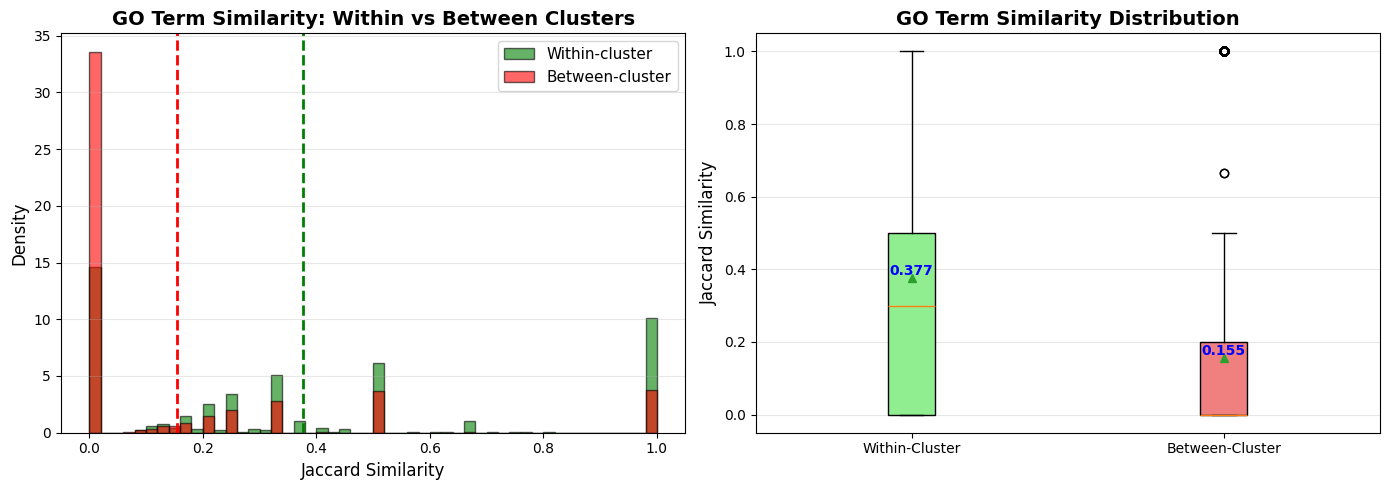


Statistical Test (t-test):
  t-statistic: 16.1126
  p-value: 4.16e-57
  Result: Highly significant difference (p < 0.001)


In [ ]:
# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution comparison
axes[0].hist(within_cluster_similarities, bins=50, alpha=0.6, label='Within-cluster', 
             edgecolor='black', color='green', density=True)
axes[0].hist(between_cluster_similarities, bins=50, alpha=0.6, label='Between-cluster', 
             edgecolor='black', color='red', density=True)
axes[0].set_xlabel('Jaccard Similarity', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('GO Term Similarity: Within vs Between Clusters', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axvline(np.mean(within_cluster_similarities), color='green', linestyle='--', linewidth=2, 
                label=f'Within mean: {np.mean(within_cluster_similarities):.3f}')
axes[0].axvline(np.mean(between_cluster_similarities), color='red', linestyle='--', linewidth=2, 
                label=f'Between mean: {np.mean(between_cluster_similarities):.3f}')

# Box plot comparison
data_to_plot = [within_cluster_similarities, between_cluster_similarities]
box = axes[1].boxplot(data_to_plot, labels=['Within-Cluster', 'Between-Cluster'],
                       patch_artist=True, showmeans=True)
box['boxes'][0].set_facecolor('lightgreen')
box['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Jaccard Similarity', fontsize=12)
axes[1].set_title('GO Term Similarity Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add mean values as text
for i, (data, pos) in enumerate(zip(data_to_plot, [1, 2])):
    mean_val = np.mean(data)
    axes[1].text(pos, mean_val, f'{mean_val:.3f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color='blue')

plt.tight_layout()
plt.show()

# Statistical test
from scipy import stats
t_stat, p_value = stats.ttest_ind(within_cluster_similarities, between_cluster_similarities)
print(f"\nStatistical Test (t-test):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.2e}")
if p_value < 0.001:
    print(f"  Result: Highly significant difference (p < 0.001)")
elif p_value < 0.05:
    print(f"  Result: Significant difference (p < 0.05)")
else:
    print(f"  Result: No significant difference (p >= 0.05)")

### Examples

In [ ]:
# Analyze specific clusters - show examples of high vs low similarity clusters
print("\n" + "="*80)
print("CLUSTER EXAMPLES")
print("="*80)

# Sort clusters by average pairwise similarity
cluster_diversity_df_sorted = cluster_diversity_df.sort_values('avg_pairwise_similarity', ascending=False)

print("\n📊 Top 5 clusters with HIGHEST internal GO term similarity:")
print("-" * 80)
for idx, row in cluster_diversity_df_sorted.head(5).iterrows():
    cluster_id = row['cluster_id']
    members = cluster_to_members[cluster_id]
    print(f"\nCluster: {cluster_id}")
    print(f"  Members: {row['num_members']}")
    print(f"  Avg pairwise similarity: {row['avg_pairwise_similarity']:.4f}")
    print(f"  Unique GO terms: {row['num_unique_terms']}")
    print(f"  Avg terms per member: {row['avg_terms_per_member']:.1f}")
    
    # Show GO terms for first few members
    print(f"  Sample GO terms:")
    for i, member_id in enumerate(members[:3]):
        if member_id in gt_dict:
            terms = list(gt_dict[member_id])[:5]  # Show first 5 terms
            print(f"    Member {i+1}: {', '.join(terms)}")

print("\n\n📊 Top 5 clusters with LOWEST internal GO term similarity:")
print("-" * 80)
for idx, row in cluster_diversity_df_sorted.tail(5).iterrows():
    cluster_id = row['cluster_id']
    members = cluster_to_members[cluster_id]
    print(f"\nCluster: {cluster_id}")
    print(f"  Members: {row['num_members']}")
    print(f"  Avg pairwise similarity: {row['avg_pairwise_similarity']:.4f}")
    print(f"  Unique GO terms: {row['num_unique_terms']}")
    print(f"  Avg terms per member: {row['avg_terms_per_member']:.1f}")
    
    # Show GO terms for first few members
    print(f"  Sample GO terms:")
    for i, member_id in enumerate(members[:3]):
        if member_id in gt_dict:
            terms = list(gt_dict[member_id])[:5]  # Show first 5 terms
            print(f"    Member {i+1}: {', '.join(terms)}")


CLUSTER EXAMPLES

📊 Top 5 clusters with HIGHEST internal GO term similarity:
--------------------------------------------------------------------------------

Cluster: 1.0
  Members: 2.0
  Avg pairwise similarity: 1.0000
  Unique GO terms: 1.0
  Avg terms per member: 1.0
  Sample GO terms:
    Member 1: GO:0005515
    Member 2: GO:0005515

Cluster: 2.0
  Members: 2.0
  Avg pairwise similarity: 1.0000
  Unique GO terms: 1.0
  Avg terms per member: 1.0
  Sample GO terms:
    Member 1: GO:0005515
    Member 2: GO:0005515

Cluster: 29.0
  Members: 3.0
  Avg pairwise similarity: 1.0000
  Unique GO terms: 1.0
  Avg terms per member: 1.0
  Sample GO terms:
    Member 1: GO:0005213
    Member 2: GO:0005213
    Member 3: GO:0005213

Cluster: 32.0
  Members: 2.0
  Avg pairwise similarity: 1.0000
  Unique GO terms: 1.0
  Avg terms per member: 1.0
  Sample GO terms:
    Member 1: GO:0005515
    Member 2: GO:0005515

Cluster: 52.0
  Members: 2.0
  Avg pairwise similarity: 1.0000
  Unique GO terms:

### Per-Cluster F1 Scores

Compute F1 scores for each cluster to see which clusters have better performance.

In [25]:
# Compute F-max function (adapted from test.py)
def compute_f1_get_list(gt_dict, predictions_array, entry_ids, terms_lists, threshold=0.5, ia_df=None):

    # Build IA dictionary if provided
    ia_dict = {}
    use_ia_weighting = ia_df is not None
    if use_ia_weighting:
        ia_dict = dict(zip(ia_df['terms'], ia_df['ia']))
        print(f"Using IA weighting with {len(ia_dict)} terms")
    
    print(f"Building prediction dictionary with threshold >= {threshold}...")
    # Build prediction dict by filtering predictions above threshold
    pred_dict = {}
    for i in range(len(entry_ids)):
        entry_id = entry_ids[i]
        terms = terms_lists[i]
        scores = predictions_array[i]
        
        # Filter by threshold
        above_threshold_indices = np.where(scores >= threshold)[0]
        pred_terms = set(terms[idx] for idx in above_threshold_indices)
        
        if pred_terms:  # Only add if there are predictions above threshold
            pred_dict[entry_id] = pred_terms
    
    print(f"Total entries with predictions: {len(pred_dict)}")
    print(f"Total entries with ground truth: {len(gt_dict)}")
    
    # Get all entry IDs
    all_entries = set(gt_dict.keys()) | set(pred_dict.keys())
    
    # Calculate per-entry metrics for macro averaging
    precisions = []
    recalls = []
    f1_scores = []
    
    total_tp = 0.0
    total_fp = 0.0
    total_fn = 0.0
    
    for entry_id in all_entries:
        true_terms = gt_dict.get(entry_id, set())
        pred_terms = pred_dict.get(entry_id, set())
        
        if use_ia_weighting:
            # Weighted by IA scores
            tp = sum(ia_dict.get(term, 0.0) for term in (true_terms & pred_terms))
            fp = sum(ia_dict.get(term, 0.0) for term in (pred_terms - true_terms))
            fn = sum(ia_dict.get(term, 0.0) for term in (true_terms - pred_terms))
        else:
            # Unweighted (count)
            tp = len(true_terms & pred_terms)
            fp = len(pred_terms - true_terms)
            fn = len(true_terms - pred_terms)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        # Calculate per-entry metrics
        entry_precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        entry_recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        entry_f1 = 2 * entry_precision * entry_recall / (entry_precision + entry_recall) if (entry_precision + entry_recall) > 0 else 0.0
        
        precisions.append(entry_precision)
        recalls.append(entry_recall)
        f1_scores.append(entry_f1)
    

    return {
        'precision': precisions,
        'recall': recalls,
        'f1' : f1_scores
    }

metrics_full = compute_f1_get_list(gt_dict, predictions_list, entry_ids_list, term_list, threshold=0.5, ia_df=ia_df)

Using IA weighting with 40122 terms
Building prediction dictionary with threshold >= 0.5...
Total entries with predictions: 48032
Total entries with ground truth: 57960


In [26]:
metric_df = pd.DataFrame({'entry' : entry_ids_list, 
                          'precision': metrics_full['precision'],
                          'recall': metrics_full['recall'],
                          'f1': metrics_full['f1'],
                          })

#reverse cluster to memeber

metric_df['cluster'] = metric_df['entry'].map(prot_to_cluster)
metric_df.head()

,entry,precision,recall,f1,cluster
0,A0A023FBW4,0.283092,1.000000,0.441265,2012
1,A0A023FBW7,0.092340,0.015402,0.026400,22544
2,A0A023FDY8,0.108248,1.000000,0.195349,22544
3,A0A023FF81,0.000000,0.000000,0.000000,2012
4,A0A023FFB5,1.000000,0.070703,0.132069,30652


In [27]:
cluster_metrics_df = metric_df.groupby('cluster').agg(
                            count =('entry', 'count'),
                            precision = ('precision', 'mean'),
                            recall = ('recall', 'mean'),
                            f1 = ('f1', 'mean')
                        ).reset_index()
cluster_metrics_df.head()

,cluster,count,precision,recall,f1
0,0,1,1.000000,0.991273,0.995617
1,1,2,1.000000,0.386922,0.461149
2,2,2,0.627941,1.000000,0.703747
3,3,1,0.000000,0.000000,0.000000
4,4,1,0.578921,1.000000,0.733312


Text(0, 0.5, 'F1')

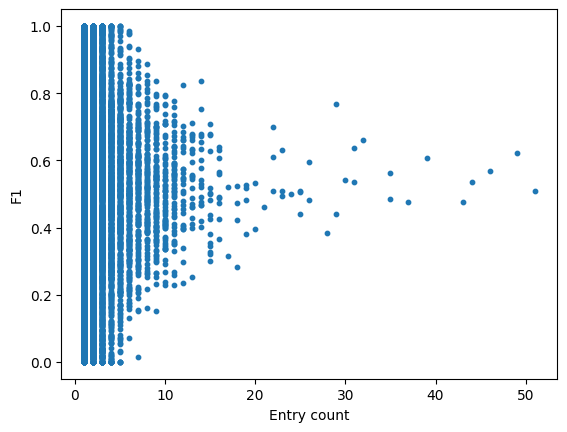

In [28]:
plt.scatter(cluster_metrics_df['count'], cluster_metrics_df['f1'], s=10)
plt.xlabel('Entry count')
plt.ylabel('F1')

In [22]:
#Train Val Split Analysis
train_ids_path =      "/mnt/d/ML/Kaggle/CAFA6-new/mmseq/train_ids.txt"
val_ids_path   =      "/mnt/d/ML/Kaggle/CAFA6-new/mmseq/val_ids.txt"

train_seq_ids = pd.read_csv(train_ids_path, header=None)
val_seq_ids = pd.read_csv(val_ids_path, header=None)

train_ids= list(train_seq_ids[0].str.split('|').str[1].tolist())
val_ids  = list(val_seq_ids[0].str.split('|').str[1].tolist())

In [29]:
#check mean f1 for train and val
train_metrics = metric_df[metric_df['entry'].isin(train_ids)]
val_metrics   = metric_df[metric_df['entry'].isin(val_ids)]

print(f"Train set mean F1: {train_metrics['f1'].mean():.4f} over {len(train_metrics)} entries")
print(f"Val set mean F1:   {val_metrics['f1'].mean():.4f} over {len(val_metrics)} entries")

Train set mean F1: 0.5195 over 46353 entries
Val set mean F1:   0.5227 over 11607 entries


# ------OLD------------

In [17]:
# Function to compute metrics for specific term sets
def compute_metrics_for_terms(predictions_df, ground_truth_df, term_set, label=""):
    """
    Compute metrics for a specific set of terms.
    """
    # Filter to only the terms of interest
    pred_filtered = predictions_df[predictions_df['term'].isin(term_set)].copy()
    gt_filtered = ground_truth_df[ground_truth_df['term'].isin(term_set)].copy()
    
    print(f"\n=== {label} ===")
    print(f"Predictions: {len(pred_filtered)} records across {pred_filtered['EntryID'].nunique()} proteins")
    print(f"Ground truth: {len(gt_filtered)} records across {gt_filtered['EntryID'].nunique()} proteins")
    
    # Build ground truth dict
    gt_dict = {}
    for entry_id, group in gt_filtered.groupby('EntryID'):
        gt_dict[entry_id] = set(group['term'].values)
    
    # Build prediction dict
    pred_dict = {}
    for entry_id, group in pred_filtered.groupby('EntryID'):
        pred_dict[entry_id] = set(group['term'].values)
    
    # Get all entry IDs that have either predictions or ground truth for these terms
    all_entries = set(gt_dict.keys()) | set(pred_dict.keys())
    
    if len(all_entries) == 0:
        print("No entries found!")
        return None
    
    # Calculate per-entry metrics for macro averaging
    precisions = []
    recalls = []
    f1_scores = []
    
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    for entry_id in all_entries:
        true_terms = gt_dict.get(entry_id, set())
        pred_terms = pred_dict.get(entry_id, set())
        
        tp = len(true_terms & pred_terms)
        fp = len(pred_terms - true_terms)
        fn = len(true_terms - pred_terms)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        # Calculate per-entry metrics (only for entries with predictions or ground truth)
        if (tp + fp) > 0 or (tp + fn) > 0:
            entry_precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            entry_recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            entry_f1 = 2 * entry_precision * entry_recall / (entry_precision + entry_recall) if (entry_precision + entry_recall) > 0 else 0.0
            
            precisions.append(entry_precision)
            recalls.append(entry_recall)
            f1_scores.append(entry_f1)
    
    # Macro-average
    macro_precision = np.mean(precisions) if precisions else 0.0
    macro_recall = np.mean(recalls) if recalls else 0.0
    macro_f1 = np.mean(f1_scores) if f1_scores else 0.0
    
    # Micro-average
    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0
    
    print(f"Total TP: {total_tp}, FP: {total_fp}, FN: {total_fn}")
    print(f"Macro - Precision: {macro_precision:.4f}, Recall: {macro_recall:.4f}, F1: {macro_f1:.4f}")
    print(f"Micro - Precision: {micro_precision:.4f}, Recall: {micro_recall:.4f}, F1: {micro_f1:.4f}")
    
    return {
        'label': label,
        'num_proteins': len(all_entries),
        'num_predictions': len(pred_filtered),
        'num_ground_truth': len(gt_filtered),
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn
    }

# Compute metrics for easy and hard classes
easy_metrics = compute_metrics_for_terms(pred_df_topk, gt_df, easy_terms, "EASY CLASSES (Top 5 Most Frequent)")
hard_metrics = compute_metrics_for_terms(pred_df_topk, gt_df, hard_terms, "HARD CLASSES (Top 5 Least Frequent)")


=== EASY CLASSES (Top 5 Most Frequent) ===
Predictions: 98884 records across 49929 proteins
Ground truth: 37855 records across 32196 proteins
Total TP: 37587, FP: 61297, FN: 268
Macro - Precision: 0.4314, Recall: 0.6420, F1: 0.4926
Micro - Precision: 0.3801, Recall: 0.9929, F1: 0.5498

=== HARD CLASSES (Top 5 Least Frequent) ===
Predictions: 136 records across 136 proteins
Ground truth: 5 records across 5 proteins
Total TP: 5, FP: 131, FN: 0
Macro - Precision: 0.0368, Recall: 0.0368, F1: 0.0368
Micro - Precision: 0.0368, Recall: 1.0000, F1: 0.0709



COMPARISON: Easy vs Hard Classes
                              label  num_proteins  macro_precision  macro_recall  macro_f1  micro_precision  micro_recall  micro_f1
 EASY CLASSES (Top 5 Most Frequent)         49934         0.431352      0.642005  0.492608         0.380112       0.99292  0.549763
HARD CLASSES (Top 5 Least Frequent)           136         0.036765      0.036765  0.036765         0.036765       1.00000  0.070922


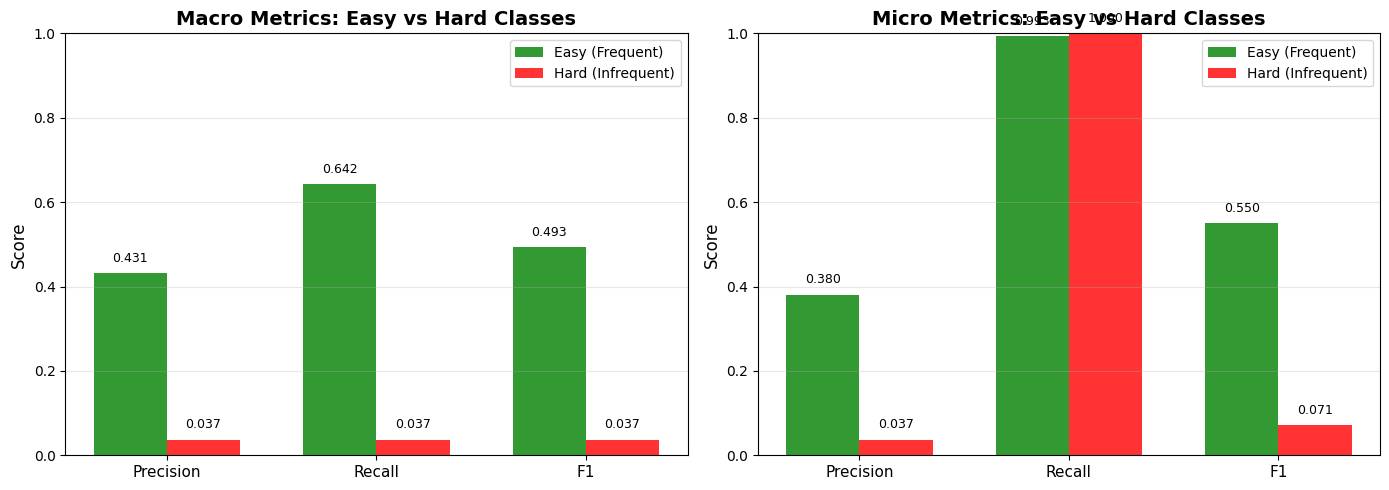


📊 Performance Gap (Macro F1): 0.4558
   Easy classes perform 1239.9% better


In [18]:
# Create comparison table
comparison_df = pd.DataFrame([easy_metrics, hard_metrics])
print("\n" + "="*80)
print("COMPARISON: Easy vs Hard Classes")
print("="*80)
print(comparison_df[['label', 'num_proteins', 'macro_precision', 'macro_recall', 'macro_f1', 
                     'micro_precision', 'micro_recall', 'micro_f1']].to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Macro metrics
metrics_to_plot = ['macro_precision', 'macro_recall', 'macro_f1']
x = np.arange(len(metrics_to_plot))
width = 0.35

easy_vals = [easy_metrics[m] for m in metrics_to_plot]
hard_vals = [hard_metrics[m] for m in metrics_to_plot]

axes[0].bar(x - width/2, easy_vals, width, label='Easy (Frequent)', alpha=0.8, color='green')
axes[0].bar(x + width/2, hard_vals, width, label='Hard (Infrequent)', alpha=0.8, color='red')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Macro Metrics: Easy vs Hard Classes', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# Add value labels on bars
for i, (easy_val, hard_val) in enumerate(zip(easy_vals, hard_vals)):
    axes[0].text(i - width/2, easy_val + 0.02, f'{easy_val:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, hard_val + 0.02, f'{hard_val:.3f}', ha='center', va='bottom', fontsize=9)

# Micro metrics
metrics_to_plot = ['micro_precision', 'micro_recall', 'micro_f1']
easy_vals = [easy_metrics[m] for m in metrics_to_plot]
hard_vals = [hard_metrics[m] for m in metrics_to_plot]

axes[1].bar(x - width/2, easy_vals, width, label='Easy (Frequent)', alpha=0.8, color='green')
axes[1].bar(x + width/2, hard_vals, width, label='Hard (Infrequent)', alpha=0.8, color='red')
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Micro Metrics: Easy vs Hard Classes', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.0])

# Add value labels on bars
for i, (easy_val, hard_val) in enumerate(zip(easy_vals, hard_vals)):
    axes[1].text(i - width/2, easy_val + 0.02, f'{easy_val:.3f}', ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, hard_val + 0.02, f'{hard_val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 Performance Gap (Macro F1): {easy_metrics['macro_f1'] - hard_metrics['macro_f1']:.4f}")
print(f"   Easy classes perform {(easy_metrics['macro_f1'] / hard_metrics['macro_f1'] - 1) * 100:.1f}% better" if hard_metrics['macro_f1'] > 0 else "")

In [ ]:
# Now test with different top-k values
top_k_values = [2, 4, 8, 16, 32]

results = []

for k in top_k_values:
    print(f"\n{'='*60}")
    print(f"=== Metrics with TOP-{k} predictions per sample ===")
    print(f"{'='*60}")
    
    # Create top-k predictions
    pred_df_topk, _ = create_topk_predictions_df(
        predictions_list, true_list, entry_ids_list, terms_list, top_k=k
    )
    
    print(f"Total predictions (top-{k}): {len(pred_df_topk)}")
    print(f"Avg predictions per protein: {len(pred_df_topk) / pred_df_topk['EntryID'].nunique():.2f}")
    
    # Compute metrics
    metrics = compute_f1(pred_df_topk, gt_df, ia_df)
    metrics['top_k'] = k
    results.append(metrics)
    print()

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("SUMMARY: F1 Scores by Top-K")
print("="*60)
print(results_df[['top_k', 'precision', 'recall', 'f1']])


=== Metrics with TOP-2 predictions per sample ===
Total predictions (top-2): 115920
Avg predictions per protein: 2.00
Using IA weighting with 40122 terms
Building ground truth dictionary...
Total IA-weighted TP: 99100.10, FP: 108915.16, FN: 108962.10
Macro Precision: 0.5276
Macro Recall: 0.6014
Macro F1: 0.4569


=== Metrics with TOP-4 predictions per sample ===
Total predictions (top-4): 231840
Avg predictions per protein: 4.00
Using IA weighting with 40122 terms
Building ground truth dictionary...
Total IA-weighted TP: 143536.52, FP: 357914.95, FN: 64525.67
Macro Precision: 0.3273
Macro Recall: 0.7403
Macro F1: 0.3646


=== Metrics with TOP-8 predictions per sample ===
Total predictions (top-8): 463680
Avg predictions per protein: 8.00
Using IA weighting with 40122 terms
Building ground truth dictionary...
Total IA-weighted TP: 175668.43, FP: 1061977.67, FN: 32393.77
Macro Precision: 0.1737
Macro Recall: 0.8289
Macro F1: 0.2374


=== Metrics with TOP-16 predictions per sample ===
To

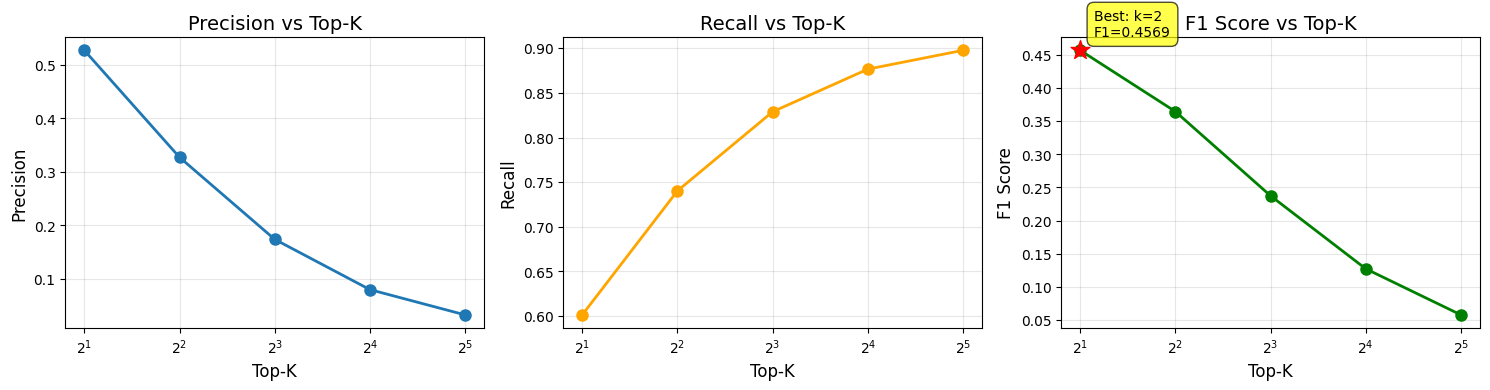


Best F1 Score: 0.4569 at Top-K = 2


In [20]:
# Visualize the results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Precision
axes[0].plot(results_df['top_k'], results_df['precision'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Top-K', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision vs Top-K', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log', base=2)

# Plot Recall
axes[1].plot(results_df['top_k'], results_df['recall'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Top-K', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall vs Top-K', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log', base=2)

# Plot F1
axes[2].plot(results_df['top_k'], results_df['f1'], marker='o', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Top-K', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_title('F1 Score vs Top-K', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].set_xscale('log', base=2)

# Mark best F1
best_idx = results_df['f1'].idxmax()
best_k = results_df.loc[best_idx, 'top_k']
best_f1 = results_df.loc[best_idx, 'f1']
axes[2].scatter([best_k], [best_f1], color='red', s=200, zorder=5, marker='*')
axes[2].annotate(f'Best: k={best_k}\nF1={best_f1:.4f}', 
                 xy=(best_k, best_f1), 
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\nBest F1 Score: {best_f1:.4f} at Top-K = {best_k}")